<a href="https://colab.research.google.com/github/sahiliem/colab/blob/main/freeCodeCamp/NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP Multi-Classification with RNN (LSTM)

In [1]:
!ls

sample_data  test.csv  train.csv


In [2]:
import pandas as pd

In [3]:
train_data = pd.read_csv(filepath_or_buffer="train.csv")
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
test_data = pd.read_csv("test.csv",encoding_errors="ignore")
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [5]:
target_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [6]:
for col in target_cols:
  print(train_data[col].value_counts(normalize=True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


**Now, prepare the data and start the training:**
1) Create a vocabulary
2) Create traininig and validation Sets
3) Create pytorch dataloaders

In [7]:
from torchtext.data.utils import get_tokenizer

In [8]:
tokenizer = get_tokenizer('basic_english')

In [9]:
# Check the first comment_text
first_comment = train_data["comment_text"][0]
first_comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
tokens = tokenizer(first_comment)
tokens[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica']

In [11]:
# Create the vocab and then input tensor
from torchtext.vocab import build_vocab_from_iterator

In [12]:
comment_text_tokens = train_data["comment_text"].map(tokenizer)
comment_text_tokens

0         [explanation, why, the, edits, made, under, my...
1         [d, ', aww, !, he, matches, this, background, ...
2         [hey, man, ,, i, ', m, really, not, trying, to...
3         [more, i, can, ', t, make, any, real, suggesti...
4         [you, ,, sir, ,, are, my, hero, ., any, chance...
                                ...                        
159566    [and, for, the, second, time, of, asking, ,, w...
159567    [you, should, be, ashamed, of, yourself, that,...
159568    [spitzer, umm, ,, theres, no, actual, article,...
159569    [and, it, looks, like, it, was, actually, you,...
159570    [and, ., ., ., i, really, don, ', t, think, yo...
Name: comment_text, Length: 159571, dtype: object

In [13]:
VOCAB_SIZE = 1500

# Special Tokens
unk_token = '<unk>'
pad_token = '<pad>'


In [14]:
vocab = build_vocab_from_iterator(comment_text_tokens,specials=[unk_token,pad_token],max_tokens=VOCAB_SIZE)

vocab.set_default_index(vocab[unk_token])
# To replace the out of vocab token since max toke size is 1500


In [15]:
vocab['explanation']

667

<Axes: ylabel='Frequency'>

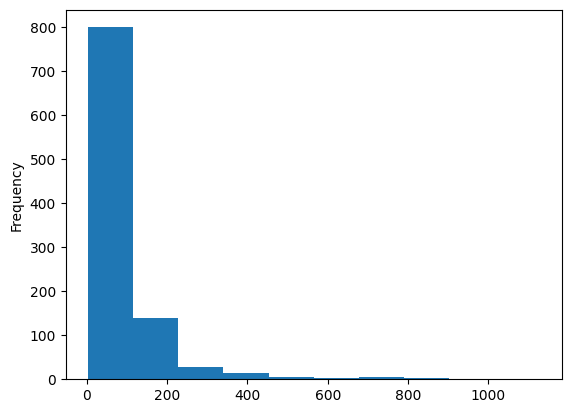

In [16]:
# How to set max lenght for tokens
train_data.head(1000)["comment_text"].map(tokenizer).map(len).plot.hist()

In [17]:
MAX_LENGTH = 105

def pad_or_trunk_tokens(tokens):
  if len(tokens) >=MAX_LENGTH:
    return tokens[:MAX_LENGTH]
  else:
    return tokens + [pad_token]*(MAX_LENGTH-len(tokens))

#pad_or_trunk_tokens(tokenizer("i love india, it is incredible"))

In [18]:
padded_or_truncated_comment_tokens = pad_or_trunk_tokens(comment_text_tokens[0])
padded_or_truncated_comment_tokens

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 '?',
 'they',
 'weren',
 "'",
 't',
 'vandalisms',
 ',',
 'just',
 'closure',
 'on',
 'some',
 'gas',
 'after',
 'i',
 'voted',
 'at',
 'new',
 'york',
 'dolls',
 'fac',
 '.',
 'and',
 'please',
 'don',
 "'",
 't',
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk',
 'page',
 'since',
 'i',
 "'",
 'm',
 'retired',
 'now',
 '.',
 '89',
 '.',
 '205',
 '.',
 '38',
 '.',
 '27',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [19]:
input_tokens = vocab.lookup_indices(padded_or_truncated_comment_tokens)
input_tokens

[667,
 85,
 3,
 140,
 142,
 185,
 39,
 663,
 0,
 0,
 1287,
 96,
 329,
 27,
 57,
 0,
 9,
 31,
 0,
 4,
 61,
 0,
 21,
 71,
 0,
 158,
 6,
 0,
 45,
 130,
 1167,
 0,
 0,
 2,
 8,
 55,
 70,
 9,
 31,
 253,
 3,
 369,
 41,
 3,
 50,
 38,
 155,
 6,
 9,
 81,
 0,
 99,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 1122,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

**Create a custom dataset for training and test**

In [20]:
from torch.utils.data import Dataset
import torch

In [21]:
class MyCustomDataset(Dataset):
  def __init__(self,dataframe,is_test=False):
    self.df = dataframe
    self.is_test = is_test

  def __getitem__(self,index):
    # Get comment_text from dataframe for an index
    comment_text = self.df["comment_text"].values[index]
    #Sentence to tokens
    comment_tokens = pad_or_trunk_tokens(tokenizer(comment_text))
    #Each token to number
    input = vocab.lookup_indices(comment_tokens)
    #number to tensor
    torch_input = torch.tensor(input)
    if self.is_test:
      torch_target = torch.tensor([0,0,0,0,0,0]).float()
    else:
      torch_target = torch.tensor(self.df[target_cols].values[index]).float()
    
    return torch_input , torch_target
  
  def __len__(self):
    return len(self.df)

In [22]:
train_dataset = MyCustomDataset(train_data)
train_dataset[0]

(tensor([ 667,   85,    3,  140,  142,  185,   39,  663,    0,    0, 1287,   96,
          329,   27,   57,    0,    9,   31,    0,    4,   61,    0,   21,   71,
            0,  158,    6,    0,   45,  130, 1167,    0,    0,    2,    8,   55,
           70,    9,   31,  253,    3,  369,   41,    3,   50,   38,  155,    6,
            9,   81,    0,   99,    2,    0,    2,    0,    2,    0,    2, 1122,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1]),
 tensor([0., 0., 0., 0., 0., 0.]))

**PyTorch DataLoaders to split the data for train and validation**

In [23]:
from torch.utils.data import random_split

In [24]:
VAL_FRAC = 0.25
train_dataset ,val_dataset = random_split(train_dataset,[1-VAL_FRAC,VAL_FRAC])

In [25]:
len(train_dataset),len(val_dataset)

(119679, 39892)

In [26]:
test_dataset = MyCustomDataset(test_data,True)
test_dataset[0]

(tensor([   0,  636,    0,  649,   12,   69,    0,   93,   10,    9,  169,  359,
           23,    0,   89,   30,   10,    8,    0,   10, 1488,    0,    2,    2,
            2,    6,   68,  636,    0,    0,    0,  690,    0,    8,  105,   10,
            5,    0,   39,  419,   10,  699,    0,   46,    2,    0,  649,   12,
           47,    0,   15,    0,  668,  439,    2,  443,    0,   13,  332,   21,
          167,    2,    8,    0,   12,  251,    0,   62,    0,   59,   34,   11,
            0,  171,    2,    2,    2,    0,  690,    0,  105,  226,  160,  490,
           95,    2,    4,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1]),
 tensor([0., 0., 0., 0., 0., 0.]))

In [27]:
from torch.utils.data import DataLoader

In [28]:
BATCH_SIZE = 256

In [29]:
train_dl = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size=BATCH_SIZE*2,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [30]:
len(train_dl),len(val_dl),len(test_dl)

(468, 78, 599)

In [31]:
for batch in train_dl:
  torch_inputs , torch_targets = batch
  print('torch_inputs ',torch_inputs.shape)
  print('torch_targets ',torch_targets.shape)

  break

torch_inputs  torch.Size([256, 105])
torch_targets  torch.Size([256, 6])


**Building a Recurrent Neural Netowrk**

In [32]:
import torch.nn as nn
import torch.functional as F

In [33]:
#Padding index
vocab[pad_token]

1

In [34]:
emb_layer = nn.Embedding(VOCAB_SIZE,256,vocab[pad_token])

In [39]:
#Create rnn layer
# Each of word vector is 256 so input size = 256
# 1 layer
# out = 128 is hidden_size The number of features in the hidden state h

rnn_layer = nn.RNN(256,128,1,batch_first=True)

In [40]:
for batch in train_dl:
  torch_inputs , torch_targets = batch
  print('torch_inputs ',torch_inputs.shape)
  print('torch_targets ',torch_targets.shape)

  emb_out= emb_layer(torch_inputs)
  print('emb_out ',emb_out.shape)

  rnn_layer, hn = rnn_layer(emb_out)
  print('rnn_layer ',rnn_layer.shape)
  print('hn ',hn.shape)

  break

torch_inputs  torch.Size([256, 105])
torch_targets  torch.Size([256, 6])
emb_out  torch.Size([256, 105, 256])
rnn_layer  torch.Size([256, 105, 128])
hn  torch.Size([1, 256, 128])


In [41]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.8 MB/s eta 0:00:00


In [44]:
import pytorch_lightning as pl

In [46]:
class Jigsawmodel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.emb= nn.Embedding(VOCAB_SIZE,256,vocab[pad_token])
    self.lstm = nn.LSTM(256,128,1,batch_first=True)
    self.linear = nn.Linear(128,6)
    pass

  def forward(self):
    pass